+ http://www.acgeospatial.co.uk/julia-prt2/  
+ http://www.acgeospatial.co.uk/julia-prt3/  
+ https://yeesian.com/ArchGDAL.jl/dev/quickstart/

In [2]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.add("FileIO")

mkpath("downloads")
mkpath("out")

using ArchGDAL; const AG = ArchGDAL

 Activating environment at `C:\Users\i am\Documents\GitHub\stage-Machine-learning\prisma\hdf5\Project.toml`
   Updating registry at `C:\Users\i am\.julia\registries\General`
  Resolving package versions...
No Changes to `C:\Users\i am\Documents\GitHub\stage-Machine-learning\prisma\hdf5\Project.toml`
No Changes to `C:\Users\i am\Documents\GitHub\stage-Machine-learning\prisma\hdf5\Manifest.toml`


ArchGDAL

In [3]:
using HDF5
include("../../code/julia/HDF5filesDict.jl")

Main.HDF5fd

In [4]:
include("../../code/julia/faux.jl")

LoadError: LoadError: syntax: unexpected "="
in expression starting at C:\Users\i am\Documents\GitHub\stage-Machine-learning\code\julia\faux.jl:38

In [5]:
include("../../code/julia/eos_get_geoloc.jl")

LoadError: could not open file C:\Users\i am\Documents\GitHub\stage-Machine-learning\code\julia\eos_get_geoloc.jl

In [6]:
using Plots

# @GeoTiff

https://en.wikipedia.org/wiki/GeoTIFF  

https://en.wikipedia.org/wiki/TIFF  

https://en.wikipedia.org/wiki/Raster_graphics

tl;dr: abbiamo un raster (matrice di pixel) con metadati (numero bande, geolocation(lat, lon)), all interno di tiff, salvati tramite ArchGDAL -> GDAL, con i dati letti dai hdf prisma(cubi vnir+swir)

dove troviamo dati geoloc in prod l2d?  
* matrice lat: hdf5\swaths\PRS_L2d_(h per hypersp cube, p per panchromatic)CO\geolocation fields\latitude  
* matrice lon: hdf5\swaths\PRS_L2d_(h per hypersp cube, p per panchromatic)CO\geolocation fields\longitude

con le due mat abbiamo latitudine/longitudine di ogni pixel del raster

dove troviamo il cubo? (raster x bande)  
* cubo vnir:  hdf5\swaths\PRS_L2d_hCO\data fields\vnir_cube  
* cubo swir:  hdf5\swaths\PRS_L2d_hCO\data fields\swir_cube  


In [7]:
openfiles = HDF5fd.filesDict()
# 1 apriamo file hdf5
f = HDF5fd.open(openfiles, "data/PRS_L2D_STD_20200627102334_20200627102339_0001.he5", "r")



HDF5 data file: data/PRS_L2D_STD_20200627102334_20200627102339_0001.he5

In [8]:
# 2 prendiamo raster di una banda

cube = faux.getData(f, "HDFEOS/SWATHS/PRS_L2D_HCO/Data Fields/SWIR_Cube");

LoadError: UndefVarError: faux not defined

In [9]:
# cubo X,band,Y, vogliamo una matrice X,Y per una banda
band = cube[:,2,:]

LoadError: UndefVarError: cube not defined

In [10]:
#nb: sparse
count(!iszero,band)/(length(band))

LoadError: UndefVarError: band not defined

In [11]:
# 3 prendiamo matrici lat e lon, risoluzione pixel
#lat = faux.getData(file, "HDFEOS/SWATHS/PRS_L2D_HCO/Geolocation Fields/Latitude")
#lon = faux.getData(file, "HDFEOS/SWATHS/PRS_L2D_HCO/Geolocation Fields/Longitude")
proc_lev = faux.getAttr(f, "Processing_Level")
source = "HCO"
wvl = "SWIR"
geo = eos_get_geoloc.get_geoloc(f,proc_lev,source,wvl,nothing)

LoadError: UndefVarError: faux not defined

In [12]:
#possiamo chiudere il file
HDF5fd.closeall(openfiles)

chiuso 1 file


In [13]:
# 4 creiamo parte metadati, per raster servono coord del pixel all angolo in alto a sinistra, risoluzione di un pixel e origine definita tramite crs
ulpixel = (x=geo.xmin,y=geo.ymax)
width = length(geo.lat[:,1])
height = length(geo.lat[1,:])
#calcoliamo risoluzione come distanza tra 
res = (geo.xmin - geo.xmax)/width# \approx (geo.ymin - geo.ymax)/height

#archgdal prende geoloc come array:
gtf = [
    ulpixel.x,#distanza in mt sull asse delle x del pixel topleft dall origine
    res,
    0,#per rotazione
    ulpixel.y,#distanza in mt sull asse delle y del pixel topleft dall origine
    0,
    -res
]
gtf = convert(Array{Float64,1}, gtf)
# creiamo stringa crs
crs = AG.toWKT(AG.importEPSG(geo.proj_epsg))

LoadError: UndefVarError: geo not defined

In [14]:
# 5 scriviamo tutto
AG.create(
    "out/temporary.tif",
    driver = AG.getdriver("GTiff"),
    width=width,
    height=height,
    nbands=1,
    dtype=UInt16
) do dataset
    AG.write!(dataset, band, 1)
    AG.setgeotransform!(dataset, gtf)
    AG.setproj!(dataset, crs)
end

LoadError: UndefVarError: width not defined

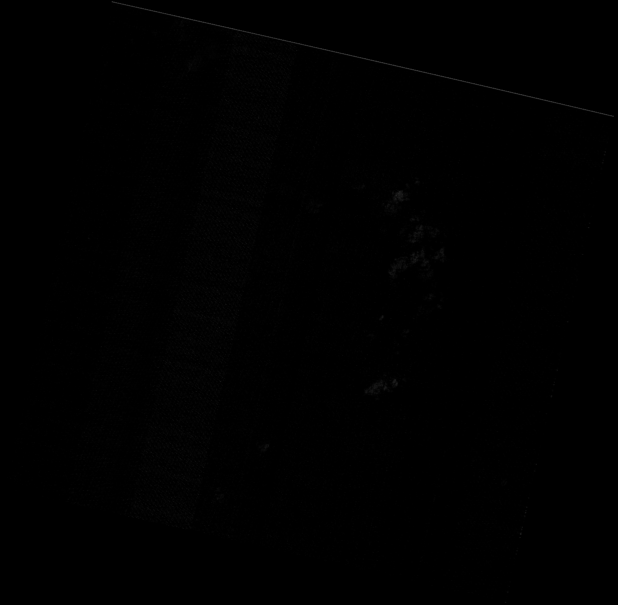

In [15]:
using Images, FileIO
# specify the path to your local image file
img_path = "out/temporary.tif"
img = load(img_path)

In [16]:
#yay

In [26]:
include("../../code/julia/eos_PANdemo.jl")

Main.eos_demo

In [1]:
#piccola demo per far vedere i pancromatici di prodotti livello 2d

hdf = "data/PRS_L2D_STD_20200627102334_20200627102339_0001.he5"
img_path = "out/mytiff2.tif"
eos_demo.demo(hdf,img_path,true)
img = load(img_path)

LoadError: UndefVarError: eos_demo not defined

In [137]:
# nuvole??????

In [29]:
rm(img_path)

LoadError: IOError: unlink: resource busy or locked (EBUSY)

In [ ]:
## geoloc errato
# risultato specchiato?